### Introduction 
In this notebook I explore the SMS Spam collection dataset and the related spam classification task.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score

In [2]:
data = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding="latin-1")
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
data.shape

(5572, 5)

In [4]:
data.isna().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

It looks like there isn't much data in the last three columns. Let's drop the last three columns and then rename the first two correctly.

In [5]:
data = data.dropna(how='any', axis=1)
data.columns = ['target', 'message']
data.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Let's take a look at how our labels are distributed:

<Axes: xlabel='target', ylabel='count'>

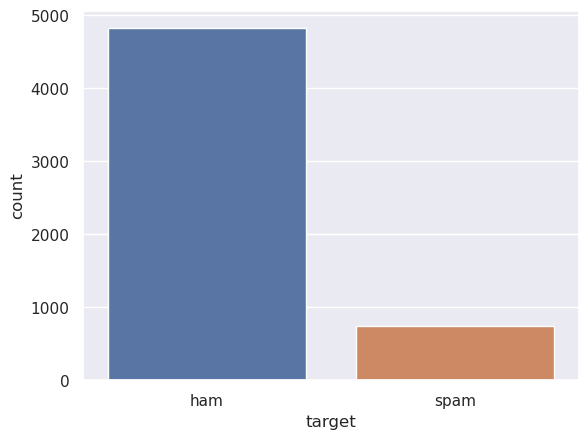

In [6]:
sns.countplot(x=data.target)

Since this is an imbalanced classification problem and there are far more ham messages than spam messages, we cannot rely solely on accuracy to asses our model, we should consider precision and recall as well. Let's explore message lengths:

In [7]:
data['word_length'] = data['message'].apply(lambda x: len(x.split(' ')))
data['char_length'] = data['message'].apply(len)


(0.0, 75.0)

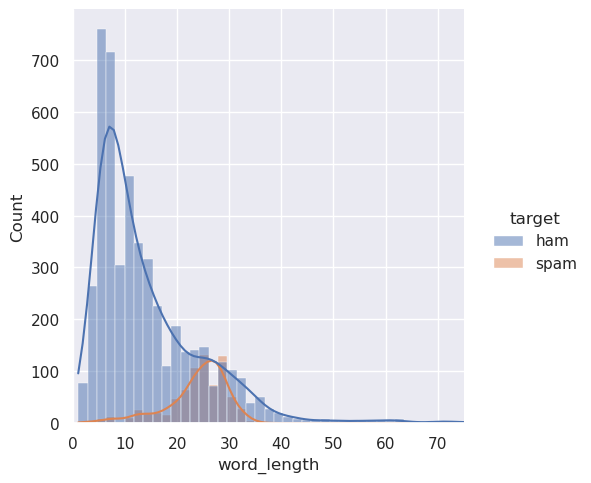

In [8]:
sns.displot(data, x='word_length', hue='target', kde=True)
plt.xlim(0,75)

(0.0, 300.0)

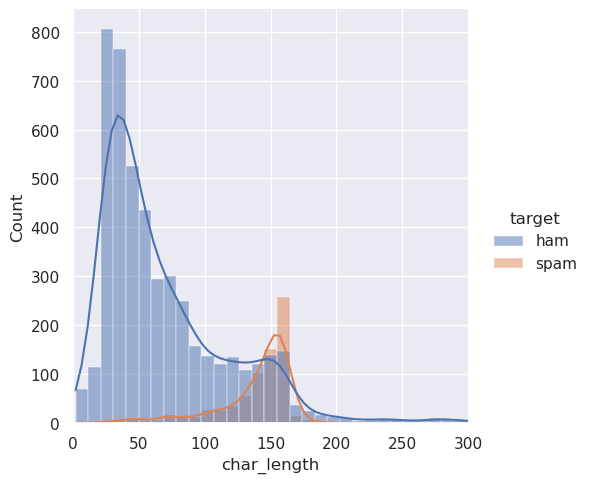

In [9]:
sns.displot(data, x='char_length', hue='target', kde=True)
plt.xlim(0,300)

It seems like short messages are more likely to be ham, most spam messages are under 200 characters and of moderate word count. I've truncated the graphs to better show the distributions, there are longer messages, although quite rare and almost exclusively ham. 

### Data preparation and cleaning

Before we can use the data, we should clean the texts to remove punctuations and stopwords. There's a note here to be made about the origin of the text messages: a significant portion of the Ham messages are sourced from a Singaporean context and contain typical Singaporean expressions like "leh/lah" or "hor". The Spam messages all come from the UK, where these expressions are not widely used. There is a case to be made that we should include these Singaporean expressions in the list of stopwords to be removed because otherwise the model would learn that the presence of such an expression signals a ham message. On the other hand, spam messages are unlikely to contain an expression of this sort, which typically arises organically in spontaneous speech rather than in prepared speech or texts. I've chosen to leave them in, but I think this is mainly a limitation of the dataset. 

Aside from that, we will use LabelEncoder to encode the targets, and TF-IDF to vectorize the messages for training. 

In [10]:
from nltk.corpus import stopwords
import string # builtin string module 

stopword_list = stopwords.words('english')

def clean(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    text = [word for word in text.split() if word not in stopword_list]
    text = ' '.join(text)
    return text

data.message = data.message.apply(clean)


In [11]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(data.target)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

tfidf = TfidfVectorizer()
features = tfidf.fit_transform(data.message)

Let's do some hyperparamter tuning with cross validation on the three models we've imported. I'm going to assess the model using four metrics, F1, accuracy, recall, and precision. I want to use F1 primarily over accuracy because there is a significant (but not severe) imbalance in classes (e.g., a classifier could get 80+% accuracy by simply saying everything is "ham")

In [13]:
from sklearn.model_selection import GridSearchCV
import copy

scoring = ['f1', 'accuracy', 'recall', 'precision']
gs = GridSearchCV(MultinomialNB(), param_grid={'alpha': np.linspace(0.05, 1, num=20)}, scoring=scoring, refit='f1')
X = copy.deepcopy(features)
y = copy.deepcopy(target)

gs.fit(X, y)
results = gs.cv_results_

I'll define a function for plotting the results of the cross validation

In [14]:
def plot_crossval_results(crossval_results, param_key):
    X_axis = np.array(crossval_results[param_key].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ['r', "k", 'b', "g"]):
        sample_score_mean = crossval_results["mean_test_%s" % (scorer)]
        sample_score_std = crossval_results["std_test_%s" % (scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            '-',
            color=color,
            alpha=1,
            label="%s" % (scorer),
        )

        best_index = np.nonzero(crossval_results["rank_test_%s" % scorer] == 1)[0][0]
        best_score = crossval_results["mean_test_%s" % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot(
            [
                X_axis[best_index],
            ]
            * 2,
            [0, best_score],
            linestyle="-.",
            color=color,
            marker="x",
            markeredgewidth=3,
            ms=8,
        )

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))


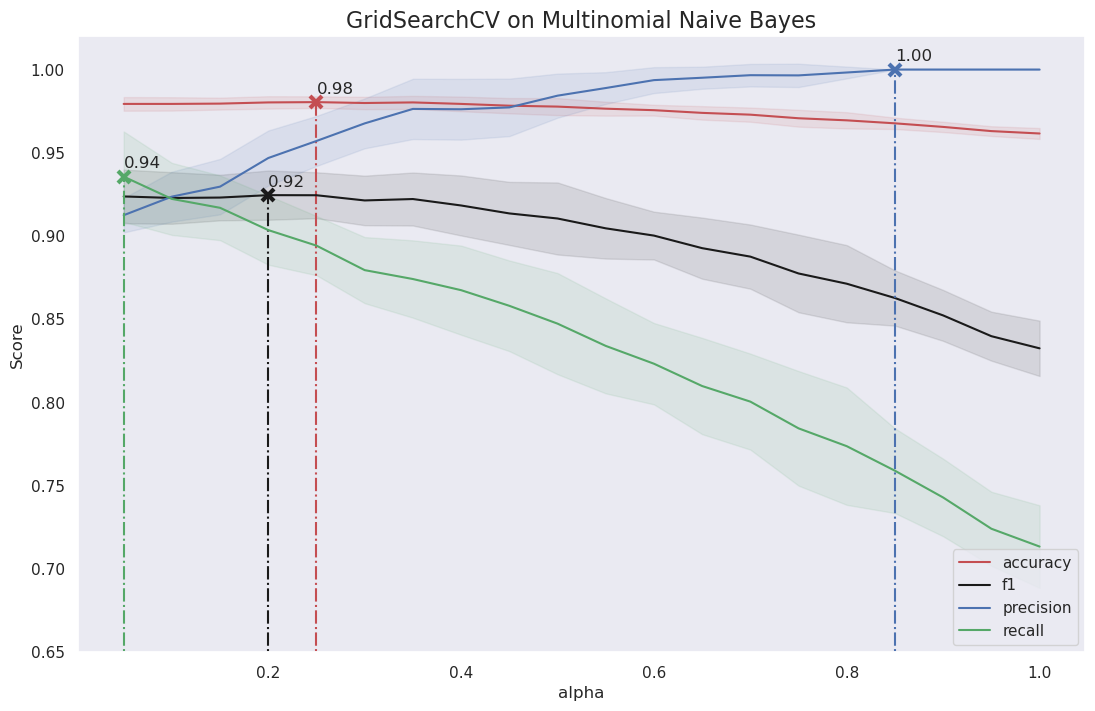

In [15]:
plt.figure(figsize=(13, 8))
plt.title("GridSearchCV on Multinomial Naive Bayes", fontsize=16)

plt.xlabel("alpha")
plt.ylabel("Score")

ax = plt.gca()
ax.set_ylim(0.65, 1.02)

plot_crossval_results(results, 'param_alpha')

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [16]:
rforest_gs = GridSearchCV(RandomForestClassifier(random_state=0), param_grid={'n_estimators': range(10,50,2)}, scoring=scoring, refit='f1')
rforest_gs.fit(X,y)

GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'n_estimators': range(10, 50, 2)}, refit='f1',
             scoring=['f1', 'accuracy', 'recall', 'precision'])

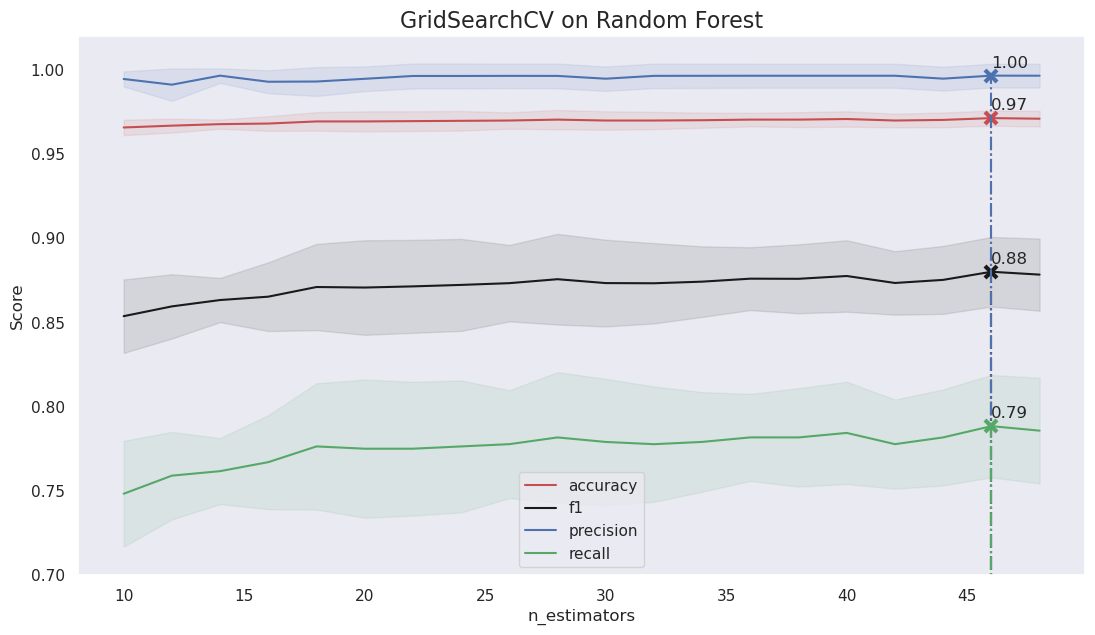

In [17]:
plt.figure(figsize=(13, 7))
plt.title("GridSearchCV on Random Forest", fontsize=16)

plt.xlabel("n_estimators")
plt.ylabel("Score")

ax = plt.gca()
ax.set_ylim(0.7, 1.02)

plot_crossval_results(rforest_gs.cv_results_, 'param_n_estimators')

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [18]:
svc_gs = GridSearchCV(
    SVC(random_state=0),
    param_grid={'kernel': ['linear', 'poly', 'sigmoid', 'rbf']},
    scoring=scoring, refit='f1'
)
svc_gs.fit(X,y)

GridSearchCV(estimator=SVC(random_state=0),
             param_grid={'kernel': ['linear', 'poly', 'sigmoid', 'rbf']},
             refit='f1', scoring=['f1', 'accuracy', 'recall', 'precision'])

In [19]:
scores = {}
for metric in ['f1', 'accuracy', 'recall', 'precision']:
    for i in range(5):
        key = 'split{}_test_{}'.format(i, metric)
        scores[key] = svc_gs.cv_results_[key]

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


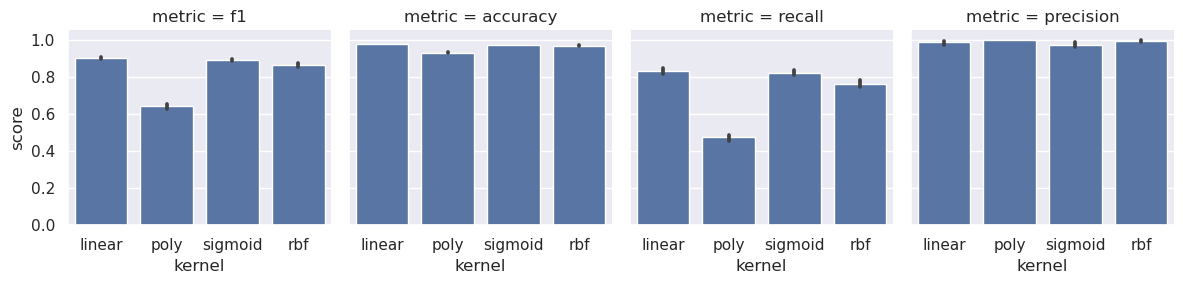

In [20]:
scores = pd.DataFrame.from_dict(scores, orient='index', columns=['linear', 'poly', 'sigmoid', 'rbf'])
scores['metric'] = ['f1' for i in range(5)] + ['accuracy' for i in range(5)] + ['recall' for i in range(5)] + ['precision' for i in range(5)]
melted_scores = scores.melt(id_vars=['metric'], var_name='kernel', value_name='score')
g = sns.FacetGrid(melted_scores, col='metric')
g.map(sns.barplot, 'kernel', 'score')

This graph isn't the best, so let's use the "best score" from the cross validation results to show us the actual values

In [21]:
svc_gs.best_score_, svc_gs.best_estimator_

(0.8995600474419844, SVC(kernel='linear', random_state=0))

The linear kernel performs best here, but the sigmoid kernel isn't far behind (and is marginally faster). 

The SVC model performs a bit better than the random forest model does, but the naive Bayes model seems to perform the best and is fast enough that it may be a good idea to store queries with known targets to use for retraining at some interval. 

As a reminder, our grid search for naive Bayes found this best score for these parameters:

In [22]:
gs.best_score_, gs.best_estimator_

(0.9245596740886901, MultinomialNB(alpha=0.2))

Now, training our final model:

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

mnb = MultinomialNB(alpha=0.2)
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2)
mnb.fit(x_train, y_train)
y_pred = mnb.predict(x_test)

And some evaluation so we can compare versus cross validation results:

{'f1': 0.9292929292929293, 'accuracy': 0.9811659192825112}

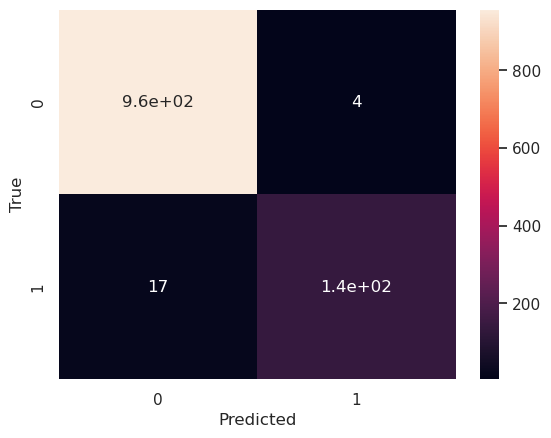

In [24]:
conf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(conf_matrix, annot=True)
ax.set(xlabel="Predicted", ylabel="True")
scores = {'f1': f1_score(y_test, y_pred), 'accuracy': accuracy_score(y_test, y_pred)}
scores

This is slightly better than expected, probably a bit of an outlier result.

Let's create a pipeline with the Naive Bayes model and store this for our deployment.

In [25]:
from sklearn.pipeline import Pipeline
import pickle
pipe = Pipeline([('tfidf', tfidf), ('mnb', mnb)])
with open('/kaggle/working/pipeline.pickle', 'wb') as f:
    pickle.dump(pipe, f, protocol=5)

I've opted to use pickle here to reduce the number of dependencies, since joblib's docs suggest that since Python 3.8 and Numpy 1.16, pickle can handle large data buffers efficiently with `protocol=5`. 